In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize,Normalize
import numpy as np

In [3]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import os

In [4]:
mean=torch.tensor([0.4850, 0.4560, 0.4060])
std=torch.tensor([0.2290, 0.2240, 0.2250])

In [5]:
from unet_v2 import UNet
model=UNet(3,3)

In [6]:
model

UNet(
  (time_embed): SinusoidalPositionEmbeddings()
  (image_embed): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
  

In [8]:
#x=torch.rand((16,3,128,128))
#t=torch.rand((16,))
#print(t.shape)
#t=F.interpolate(t,(128,128),mode="nearest")
#print(x.shape)
#print(t.shape)
#z=model(x,t)
#z.shape
#t.shape

In [9]:
def losses(noise,predicted_noise, loss_type="l1"):
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [10]:
#data_name="huggan/CelebA-faces"
data_name="huggan/flowers-102-categories"
dataset = load_dataset("huggan/flowers-102-categories")
image_size = 128
channels = 3
batch_size = 24

Using custom data configuration huggan--flowers-102-categories-2ab3d0588f2a8da7
Found cached dataset parquet (/home/ubuntu/.cache/huggingface/datasets/huggan___parquet/huggan--flowers-102-categories-2ab3d0588f2a8da7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            Resize(image_size,antialias=True),
            CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            Normalize(mean, std)
            #transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms)
#transformed_dataset = dataset.with_transform(transforms).remove_columns("labels")

In [12]:
postprocess = Compose([
     Lambda(lambda t: (t.cpu() * std.reshape(3,1,1))+mean.reshape(3,1,1)),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
     ToPILImage(),
])

In [13]:
train_len=int(len(transformed_dataset["train"])*0.9)
val_len=len(transformed_dataset["train"])-train_len
train_set, val_set = torch.utils.data.random_split(transformed_dataset["train"],[train_len,val_len])

In [14]:
# create dataloader
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True,drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False,drop_last=True)

In [15]:
batch = next(iter(train_dataloader))
print(batch.keys()),batch["pixel_values"].shape,batch["pixel_values"].min(),batch["pixel_values"].max()

dict_keys(['pixel_values'])


(None, torch.Size([24, 3, 128, 128]), tensor(-2.1179), tensor(2.6400))

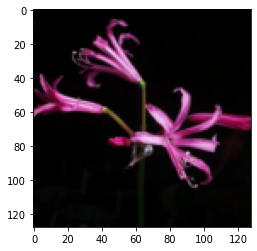

In [16]:
timg=postprocess(batch["pixel_values"][7])
plt.imshow(timg)

In [17]:
@torch.no_grad()
def cos_diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    min_signal_rate = torch.tensor(0.02).to(diffusion_times)
    max_signal_rate = torch.tensor(0.95).to(diffusion_times)
    start_angle = torch.acos(max_signal_rate)
    end_angle = torch.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    # angles -> signal and noise rates
    signal_rates = torch.cos(diffusion_angles).to(diffusion_times)
    noise_rates = torch.sin(diffusion_angles).to(diffusion_times)
    # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
    return noise_rates, signal_rates

In [18]:
@torch.no_grad()
def lin_diffusion_schedule(diffusion_times):
    # diffusion times -> angles
    min_signal_rate = torch.tensor(0.02).to(diffusion_times)
    max_signal_rate = torch.tensor(0.999).to(diffusion_times)
    diffusion_angles = min_signal_rate + diffusion_times * (max_signal_rate - min_signal_rate)
    # angles -> signal and noise rates
    signal_rates = 1.0-diffusion_angles
    noise_rates = diffusion_angles
    return noise_rates, signal_rates

In [19]:
#model = ResNet50(n_classes=channels,time_dim=32)

In [20]:
model

UNet(
  (time_embed): SinusoidalPositionEmbeddings()
  (image_embed): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
  

In [21]:
@torch.no_grad()
def reverse_diffusion(model,initial_noise, diffusion_steps,device="cuda"):
    # reverse diffusion = sampling
    #print(next(model.parameters()).device)
    num_images = initial_noise.shape[0]
    step_size = 1.0 / diffusion_steps
    # important line:
    # at the first sampling step, the "noisy image" is pure noise
    # but its signal rate is assumed to be nonzero (min_signal_rate)
    next_noisy_images = initial_noise
    all_pred_imgs=[]
    for step in tqdm(range(diffusion_steps)):
        noisy_images = next_noisy_images
        # separate the current noisy image to its components
        diffusion_times = torch.ones((num_images,1,1,1)).to(device) - step * step_size
        diffusion_times=diffusion_times.to(initial_noise)
        noise_rates, signal_rates = cos_diffusion_schedule(diffusion_times)
        pred_noises, pred_images = model.denoise(noisy_images, noise_rates, signal_rates,training=False)
        all_pred_imgs.append(pred_images)
        # remix the predicted components using the next signal and noise rates
        next_diffusion_times = diffusion_times - step_size
        next_noise_rates, next_signal_rates = cos_diffusion_schedule(next_diffusion_times)
        next_noisy_images = (next_signal_rates * pred_images + next_noise_rates * pred_noises)
        # this new noisy image will be used in the next step
        #next_noisy_images=pred_images
    # Last step
    #diffusion_times = torch.zeros((num_images,1,1,1)).to(device)
    #diffusion_times=diffusion_times.to(initial_noise)
    #noise_rates, signal_rates = lin_diffusion_schedule(diffusion_times)
    #pred_noises, pred_images = model.denoise(pred_images, noise_rates, signal_rates,training=False)
    
    return pred_images

In [22]:
@torch.no_grad()
def generate(model,num_images, diffusion_steps,device="cuda"):
    # noise -> images -> denormalized images
    initial_noise =torch.randn((num_images,channels, image_size, image_size)).to(device)
    #initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
    generated_images = reverse_diffusion(model,initial_noise, diffusion_steps)
    ims=[]
    for i in range(generated_images.shape[0]):
        ims.append(postprocess(generated_images[i]))
    return ims

In [23]:
def plot_images(images,num_rows=3, num_cols=6):
    plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
    for row in range(num_rows):
        for col in range(num_cols):
            index = row * num_cols + col
            plt.subplot(num_rows, num_cols, index + 1)
            plt.imshow(images[index])
            plt.axis("off")
    plt.tight_layout()
    #plt.show()
    return plt
   #plt.close()

In [24]:
import pytorch_lightning as pl
from ema_pytorch import EMA

class Diffusion(pl.LightningModule):

    def __init__(self, model, lr, weight_decay):
        super().__init__()
        
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        
        self.ema_network = EMA (
        self.model,
        beta = 0.999,              # exponential moving average factor
        update_after_step = 1,    # only after this number of .update() calls will it start updating
        update_every = 1,          # how often to actually update, to save on compute (updates every 10th .update() call)
        )
        self.gidx=1
    
    
    def denoise(self,noisy_images, noise_rates, signal_rates,training=True):
        # predict noise component and calculate the image component using it
        if training:
            network = self.model
        else:
            network = self.ema_network
        pred_noises = network(noisy_images, noise_rates.reshape((noise_rates.shape[0]),)**2)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images
    
    
    def forward(self, noisy_images, noisy_rates):
        outputs = self.model(noisy_images, noisy_rates)
        return outputs
    
    def losses(self,noise,predicted_noise, loss_type="l1"):
        if loss_type == 'l1':
            loss = F.l1_loss(noise, predicted_noise)
        elif loss_type == 'l2':
            loss = F.mse_loss(noise, predicted_noise)
        elif loss_type == "huber":
            loss = F.smooth_l1_loss(noise, predicted_noise)
        else:
            raise NotImplementedError()
        return loss
    
    @torch.no_grad()
    def get_noise(self,images):
        noises = torch.randn((batch_size,channels, image_size, image_size)).to(images)
        diffusion_times = torch.rand((batch_size,1,1,1)).to(images) 
        noise_rates, signal_rates = cos_diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        return noises,noise_rates,noisy_images,signal_rates
        
     
    def common_step(self, batch, batch_idx):
        images = batch["pixel_values"]
        noises,noise_rates, noisy_images,signal_rates=self.get_noise(images)
        pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates)
        noise_loss = self.losses(noises, pred_noises)
        image_loss = self.losses(images, pred_images)
        return noise_loss,{"NoiseLoss":noise_loss,"ImageLoss":image_loss}
    
    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())
        self.ema_network.update()
        return loss
    
    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss
    
    def validation_epoch_end(self,validation_step_outputs):
        self.eval()
        images=generate(self,24,200,device="cuda")
        rows=len(images)//4
        cols=len(images)//rows
        plt=plot_images(images,rows,cols)
        plt.savefig(os.path.join("./lightning_logs/simple_unet",f"{self.gidx}"+"_res.png"))
        self.train()
        self.gidx+=1

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr,weight_decay=self.weight_decay)
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [25]:
DModel = Diffusion(model=model, lr=1e-3, weight_decay=1e-5) 

In [26]:
# Load pretrained model
#ckpt_file_path="lightning_logs/LogitsLastLayer/checkpoints/flowers_diffusion-epoch=38-validation_loss=0.0600.ckpt"
#model_sd=torch.load(ckpt_file_path)["state_dict"]
#DModel.load_state_dict(model_sd)

In [27]:
# Start tensorboard.
#%load_ext tensorboard
#%tensorboard --logdir ./lightning_logs

In [28]:
from pytorch_lightning import Trainer

In [29]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    save_top_k=2,
    monitor="validation_loss",
    mode="min",
    save_last=True,
    filename="flowers_diffusion-{epoch:02d}-{validation_loss:.4f}",
)

In [30]:
logger = pl.loggers.TensorBoardLogger(save_dir='.',version='simple_unet',name='lightning_logs')

In [ ]:
trainer = Trainer(logger=logger,gpus=1, max_epochs=200,callbacks=[checkpoint_callback])
trainer.fit(DModel)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | model       | UNet | 31.1 M
1 | ema_network | EMA  | 62.1 M
-------------------------------------
31.1 M    Trainable params
31.1 M    Non-trainable params
62.1 M    Total params
248.590   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


  0%|          | 0/200 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

<ipython-input-23-e5d5f8bee13a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))


Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Validating: 0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
dir(trainer)

In [ ]:
trainer.log_dir